vif
pca
////
logit, descision tree

цель актуальность новизна, обзор статей (генерация факторов для оценки кредитоспособности 1-2 (2), материалы цб (актуальная версия - показатели эффективности банков), ) 
ewc - CB 
определение дефолтов банков 2008-2014 insolvency 

1. проверить базовые модели
2. попробовать добавить лаговые регрессоры
3. добавить методы отбора переменных
4. сделать выводы о их влиянии на модели
5. написать отчет

### Import of libraries and data

In [305]:
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.8 MB/s eta 0:00:0000:0100:010m


In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st

import sklearn
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score

from mlxtend.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings('ignore')

In [265]:
df = pd.read_excel('/Users/nikitos/Desktop/Project_method_analysis/data/Полные_данные_для_Никиты_тренировочные.xlsx')
names = pd.read_excel('/Users/nikitos/Desktop/Project_method_analysis/data/Names(2).xlsx')

In [266]:
df.head()

,licdate,regn,date,rang,default,h1,h101,h12,h2,h3,...,exp_nsc2,fch_nsc2,mds_nsc2,nra_nsc2,rus_nsc2,snp_nsc2,date3,default2,ent_name2,defaultfull
0,240360,2,40360,0.564626,0,0.0,0.60,0.0,47.970001,75.019997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
1,240452,2,40452,0.201908,0,0.0,0.03,0.0,29.790001,63.020000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
2,240544,2,40544,0.705000,0,0.0,0.10,0.0,73.769997,70.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
3,240634,2,40634,0.931361,0,0.0,0.08,0.0,24.459999,62.980000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
4,240725,2,40725,0.417946,0,0.0,0.02,0.0,36.720001,67.519997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0


In [267]:
ones = (df["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

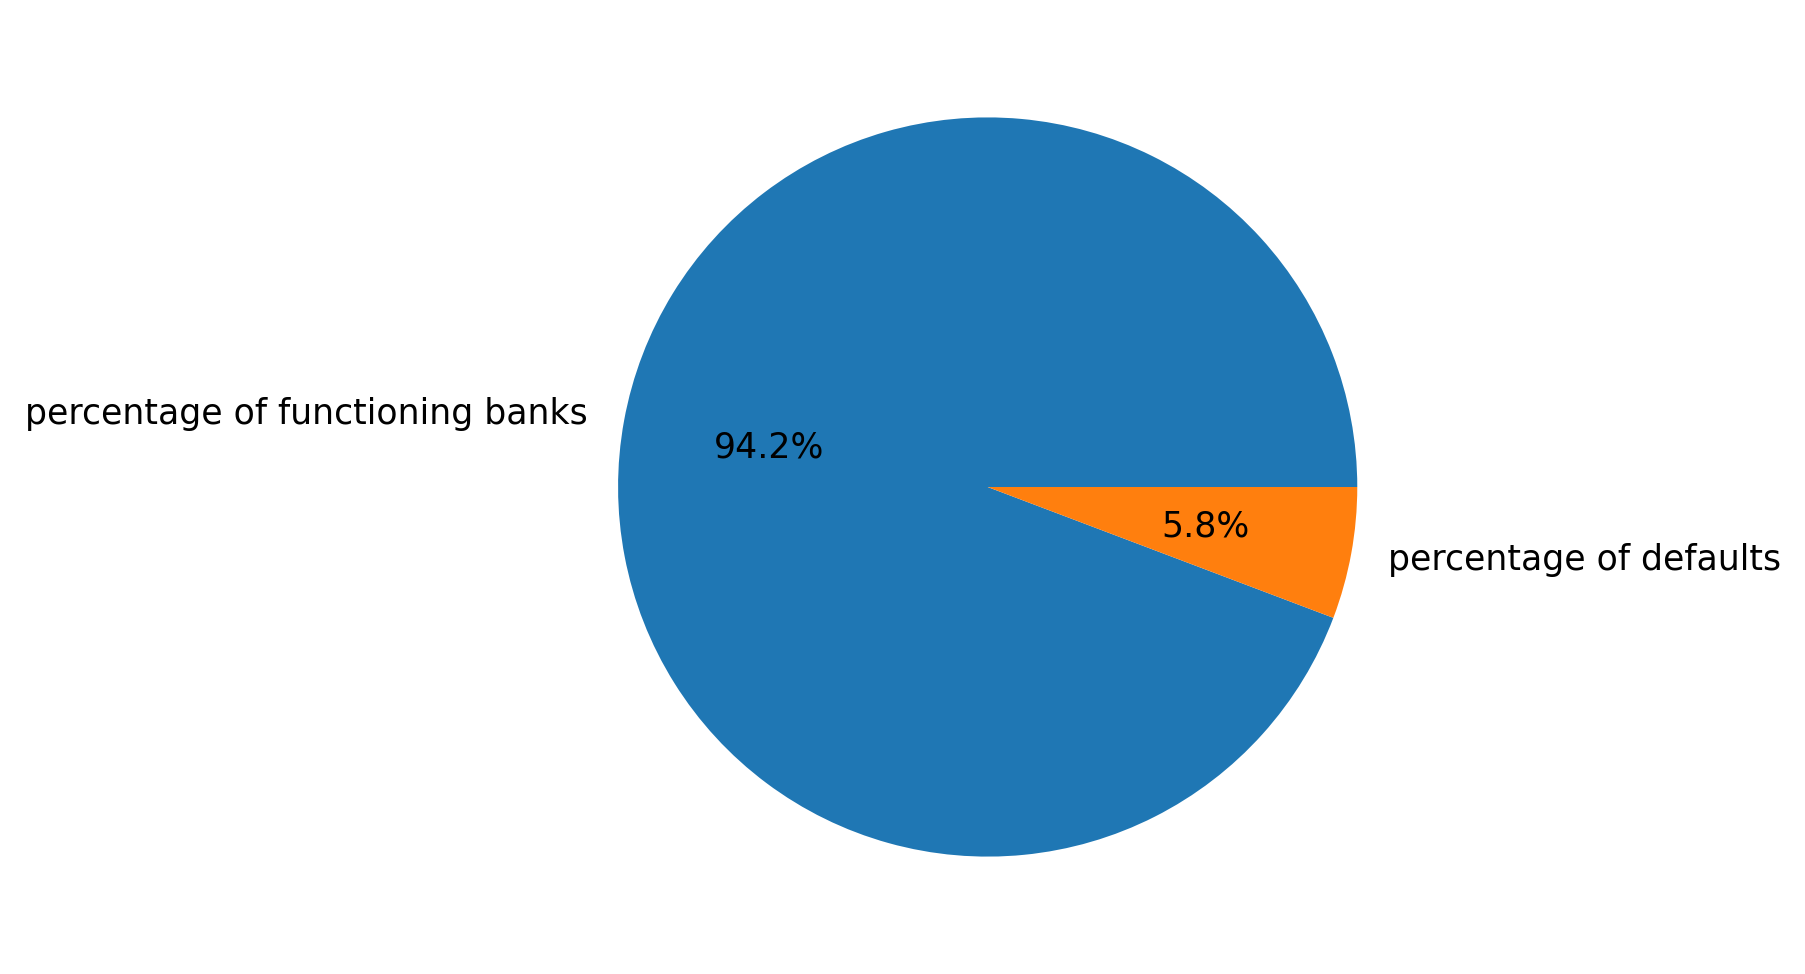

In [268]:
fig, ax = plt.subplots(dpi=250)
plt.pie([zeros, ones], labels=['percentage of functioning banks', 'percentage of defaults'], autopct='%1.1f%%');

### Creating additional explanatory variables

In [269]:
# names

In [270]:
print(list(df.columns))

['licdate', 'regn', 'date', 'rang', 'default', 'h1', 'h101', 'h12', 'h2', 'h3', 'h4', 'h7', 'h91', 'aa', 'ap', 'bl', 'ca', 'cp', 'ma', 'mp', 'op', 'or', 'r', 's', 'v', 'w', 'z', 'a_l', 'a_d', 'da', 'db', 'dc', 'df', 'dg', 'dh', 'dn', 'di', 'n', 'k', 'la', 'lb', 'lc', 'lf', 'lg', 'lh', 'li', 'ln', 'la_unknown', 'la_short', 'la_medium', 'la_long', 'lb_unknown', 'lb_short', 'lb_medium', 'lb_long', 'lc_unknown', 'lc_short', 'lc_medium', 'lc_long', 'lf_unknown', 'lf_short', 'lf_medium', 'lf_long', 'lg_unknown', 'lg_short', 'lg_medium', 'lg_long', 'lh_unknown', 'lh_short', 'lh_medium', 'lh_long', 'li_unknown', 'li_short', 'li_medium', 'li_long', 'ln_unknown', 'ln_short', 'ln_medium', 'ln_long', 'l_unknown_tot', 'l_short_tot', 'l_medium_tot', 'l_long_tot', 'active', 'size', 'nonf', 'debt_on_loan', 'durcha', 'recha', 'orcha', 'ent_id', 'consrank', 'akm_nsc', 'exp_nsc', 'fch_nsc', 'mds_nsc', 'nra_nsc', 'rus_nsc', 'snp_nsc', 'var119', 'ent_id2', 'date_str', 'ent_name', 'default3', 'okpo', 'ogrn'

In [271]:
# data_columns = []

# for c in list(df.columns):
#     if (c.find('def') != -1):
#         data_columns.append(c)

# print(len(data_columns))
# print(data_columns)

In [272]:
# df['n']

Описание полей: 

'licdate' - дата + номер лицензии
'regn', 'regn2' - номер лицензии банка
'date', 'date3' - временные пометки
'rang'
'default', 'default2', 'default3', 'defaultfull' - логические переменные для указания дефолта 
'h1', 'h101', 'h12', 'h2', 'h3', 'h4', 'h7', 'h91' - нормативы центрального банка (91, 101 - 9.1, 10.1)
'aa' - Акционерный капитал (актив)
'ap' - Акционерный капитал (пассив)
'bl'
'ca' - Счета собственного капитала (актив)
'cp' - Счета собственного капитала (пассив)
'ma' - Основные средства
'mp' - Амортизация
'op' - Прочие пассивы
'or' - Обязательные резервы
'r' - Резервы на возможные потери
's' - Купленные ценные бумаги (актив)
'v' - Драгоценные металлы 
'w' - Наличность
'z' - Выпущенные ценные бумаги (пассив)
'da' - Депозиты коммерческих организаций
'db' - Депозиты банков (МБК)
'dc' - Депозиты ЦБ
'df' - Депозиты иностранных организаций
'dg' - Депозиты государственных органов
'dh' - Депозиты домашних хозяйств
'dn' - Депозиты НКО
'di' - Депозиты финансовых организаций
'n' - 
'k' - 
'la' - Кредиты коммерческим организациям
'lb' - Кредиты банкам (МБК)
'lc' - Кредиты ЦБ
'lf' - Кредиты иностранным организациям
'lg' - Кредиты государственным органам
'lh' - Кредиты домашним хозяйствам
'li' - Кредиты финансовым организациям
'ln' - Кредиты НКО
'active' - активы
'size' - log(actives)
'nonf'
'durcha' - депозиты юр. лиц к чистым активам
'recha' - резервы к чистым активам
'orcha' - обязательные резервы к чистым активам
'var119'
'okpo'
'ogrn' - основной государственный регистрационный номер


!!! Депозиты к юр лицам = da + df, депозиты коммерческих и иностранных организаций

In [273]:
# for d in df['date'].unique():
#     print(d, df[df['date'] == d]['defaultfull'].sum())


А.М. Карминский  НИУ ВШЭ, Москва 
А.В. Костров  НИУ ВШЭ, Москва 


##### Моделирование вероятности дефолта российских банков: расширенные возможности


++++++++++ Отношение собственных средств к чистым активам - sk_ca

- Отношение балансовой прибыли к чистым активам - bp_ca

++++++++++ Отношение ликвидных активов к чистым активам - la_ca 

++++++++++ Отношение объема негосударственных ценных бумаг к чистым активам ncb_ca s_active

- Отношение просроченной задолженности по ссудам к кредитам экономике pzs_ke

- Отношение оборотов по корреспондентским счетам к чистым активам oks_ca

++++++++++ Отношение ликвидных активов к обязательствам до востребования la_ov - h2

++++++++++ Логарифм чистых активов ln_ca / SIZE 

- Отношение операционных доходов банка к чистой прибыли odb_cp

- Отношение чистой прибыли к чистым активам cp_ca

? Отношение ликвидных активов к долговым обязательствам государственным и органов местного самоуправления la_gdo

? Отношение ликвидных активов к обязательствам на срок свыше одного года la_solong

++++++++++ Отношение долговых обязательств государственных и органов местного самоуправления к чистым активам gdo_ca

Отношение работающих активов к чистым активам ra_ca

- Отношение депозитов физических лиц до 30 дней к депозитам физических лиц vdfl30_dfl

- Отношение расходов на содержание аппарата к операционным расходам банка rsa_orb

++++++++++ Отношение резервов к чистым активам res_ca - recha 

##### Feature generation

In [274]:
# sk_ca

df['ca_active'] = df['ca'] / df['active']

df['ma_active'] = df['ma'] / df['active']

df['ca+cp_active'] = df['ca'] + df['ca']
df['ca+cp_active'] = df['ca+cp_active'] / df['active']

# la_ca

df['s+w+v_active'] = df['s'] + df['v'] + df['w']
df['s+w+v_active'] = df['s+w+v_active'] / df['active']

# ncb_ca

df['s_active'] = df['s'] / df['active']

# gdo_ca

df['gdo_ca'] = df['lg']/df['active']

In [275]:
# list(df.select_dtypes(np.number).columns)

##### Ratings normalization + ratings filtration 

In [276]:
ratings = []

for c in list(df.columns):
    if (c.find('consrank') != -1) or (c.find('nsc') != -1):
        ratings.append(c)
        regul = StandardScaler()
        regul.fit(np.array(df[df[c].notnull()][c]).reshape(-1, 1))
        
        df[c] = regul.transform(np.array(df[c].fillna(regul.mean_[0])).reshape(-1, 1)).reshape(df.shape[0])
        
print(ratings)

df_ratings = df[ratings]
df['have_rating'] = df_ratings.sum(axis=1)

df['have_rating'] = df['have_rating'].apply(lambda x: 1 if x > 0 else 0)

['consrank', 'akm_nsc', 'exp_nsc', 'fch_nsc', 'mds_nsc', 'nra_nsc', 'rus_nsc', 'snp_nsc', 'consrank2', 'akm_nsc2', 'exp_nsc2', 'fch_nsc2', 'mds_nsc2', 'nra_nsc2', 'rus_nsc2', 'snp_nsc2']


<AxesSubplot:>

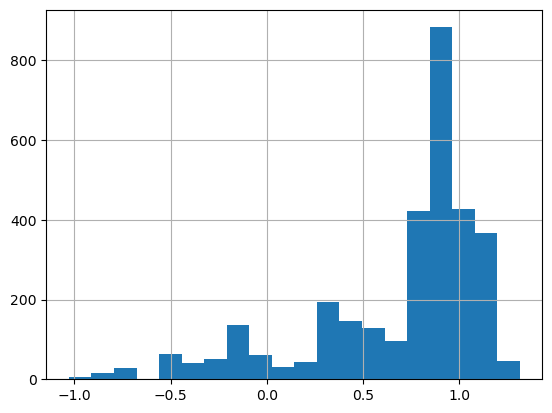

In [277]:
df[df['have_rating'] == 1]['consrank'].hist(bins=20)

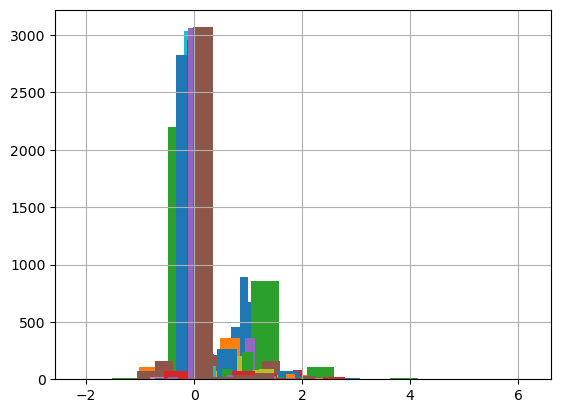

In [278]:
for i in ratings:
    df[df['have_rating'] != 0][i].hist(bins = 15)

##### Ordinal variables transformation

We have ordinal variables - date
And nominal - regn, name

In [279]:
df = df.drop(['regn2'], axis=1)
df = df.drop(['date3'], axis=1)
df = df.drop(['date_str'], axis=1)
df = df.drop(["ent_name", "ent_name2"], axis=1)

In [280]:
for col in ['nonf', 'var119']: #, 'nonf_lag_1', 'nonf_lag_2', 'var119_lag_1', 'var119_lag_2']:
    df[col] = df[col].fillna(df[col].mean())

##### Adding lags 

In [281]:
prepared = set()
filter_lag_1 = []

for el in list(df['regn']):
    
    if el in prepared:
        filter_lag_1.append(1)
        
    else:
        filter_lag_1.append(0)
        
    prepared.add(el)

filter_lag_2 = filter_lag_1.copy()

i = 0
while i < len(filter_lag_2):
    if filter_lag_2[i] == 0:
        filter_lag_2[i+1] = 0
        i += 2
    else:
        i += 1

In [282]:
df = df.sort_values(['regn', 'date'])

number_columns = df.select_dtypes(np.number).columns

exclude=set(['licdate', 'regn', 'date', 'default', 'default2', 'default3', 'defaultfull', 'date3', 'date_str', 'ent_id', 'ent_id2', 'rang', 'have_rating'])
lags_columns = []

for col in number_columns:
    if col in exclude:
        continue
        
    else:
        df[f"{col}_lag_1"] = df[col].shift(1).fillna(0)
        df[f"{col}_lag_2"] = df[col].shift(2).fillna(0)
        
        df[f"{col}_lag_1"] = df[f"{col}_lag_1"] * filter_lag_1
        df[f"{col}_lag_2"] = df[f"{col}_lag_2"] * filter_lag_2
        
        lags_columns.append(f"{col}_lag_1")
        lags_columns.append(f"{col}_lag_2")

In [283]:
# df = df.drop(lags_columns, axis=1)

##### Distribution of defaults between two datasets

In [284]:
df_with_ratings = df[df['have_rating'] == 1]
df_no_ratings = df[df['have_rating'] == 0]

df_no_ratings = df_no_ratings.drop(ratings, axis=1)

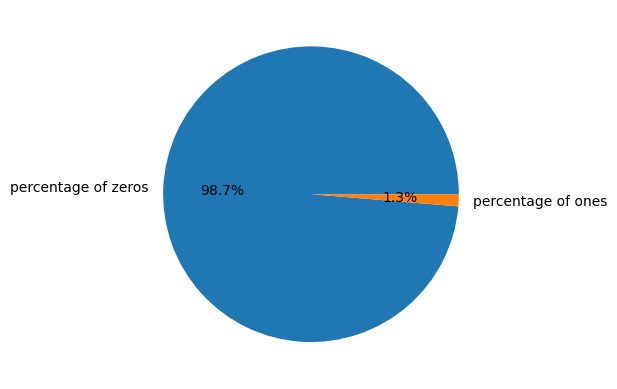

In [285]:
ones = (df_with_ratings["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');

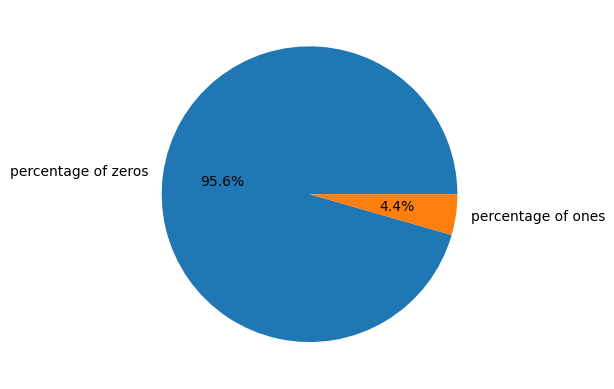

In [286]:
ones = (df_no_ratings["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');

In [287]:
# df = df.sort_values(['date'])

df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 17829,
            17830],
           dtype='int64', length=17831)

In [288]:
df.head()

,licdate,regn,date,rang,default,h1,h101,h12,h2,h3,...,ma_active_lag_1,ma_active_lag_2,ca+cp_active_lag_1,ca+cp_active_lag_2,s+w+v_active_lag_1,s+w+v_active_lag_2,s_active_lag_1,s_active_lag_2,gdo_ca_lag_1,gdo_ca_lag_2
0,240360,2,40360,0.564626,0,0.0,0.60,0.0,47.970001,75.019997,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,240452,2,40452,0.201908,0,0.0,0.03,0.0,29.790001,63.020000,...,0.004066,0.000000,0.405200,0.000000,0.020973,0.000000,0.0,0.0,0.0,0.0
2,240544,2,40544,0.705000,0,0.0,0.10,0.0,73.769997,70.250000,...,0.003349,0.004066,0.513278,0.405200,0.019406,0.020973,0.0,0.0,0.0,0.0
3,240634,2,40634,0.931361,0,0.0,0.08,0.0,24.459999,62.980000,...,0.003016,0.003349,0.609468,0.513278,0.014643,0.019406,0.0,0.0,0.0,0.0
4,240725,2,40725,0.417946,0,0.0,0.02,0.0,36.720001,67.519997,...,0.003551,0.003016,0.221099,0.609468,0.023062,0.014643,0.0,0.0,0.0,0.0


Normalization

In [289]:
"""
Hot fix
"""

cols_with_nan = df_with_ratings.isnull().describe().T
cols_with_nan = list(cols_with_nan[cols_with_nan['unique'] == 2].T.columns)

df_with_ratings = df_with_ratings.drop(cols_with_nan, axis=1)
df_no_ratings = df_no_ratings.drop(cols_with_nan, axis=1)

In [290]:
# regul = StandardScaler()

# regul.fit_transform(df_no_ratings)

In [291]:
# for c in df_no_ratings.columns:
#     regul = StandardScaler()
#     regul.fit(np.array(df[df[c].notnull()][c]).reshape(-1, 1))

#     df[c] = regul.transform(np.array(df[c].fillna(regul.mean_[0])).reshape(-1, 1)).reshape(df.shape[0])

## Models

In [292]:
"""
LogisticRegression
KNeighborsClassifier
SVC
NuSVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
"""

'\nLogisticRegression\nKNeighborsClassifier\nSVC\nNuSVC\nDecisionTreeClassifier\nRandomForestClassifier\nAdaBoostClassifier\n'

In [293]:
print(df.shape)
print(df_with_ratings.shape)
print(df_no_ratings.shape)

(17831, 341)
(3186, 335)
(14645, 319)


In [294]:
# encoder = OneHotEncoder()

# smth = encoder.fit_transform(df[['regn']])

# smth_more = zip(encoder.get_feature_names_out(['regn']), smth)

In [295]:
# k = 0

# for i in smth_more:
#     print(i[1].tolist())
#     k+= 1
#     if k == 5:
#         break

In [296]:
trash = df_with_ratings.isnull().describe().T
list(trash[trash['unique'] == 2].T.columns)

[]

In [297]:
# df[df['ent_id'].notnull()]['ent_id']

In [298]:
df_with_ratings

,licdate,regn,date,rang,default,h1,h101,h12,h2,h3,...,ma_active_lag_1,ma_active_lag_2,ca+cp_active_lag_1,ca+cp_active_lag_2,s+w+v_active_lag_1,s+w+v_active_lag_2,s_active_lag_1,s_active_lag_2,gdo_ca_lag_1,gdo_ca_lag_2
44,1840544,18,40544,0.331250,0,0.000000,0.80,0.0,30.860001,63.740002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
45,1840634,18,40634,0.592899,0,0.000000,0.88,0.0,44.910000,63.130001,...,0.018955,0.000000,0.485585,0.000000,0.241706,0.000000,0.226857,0.000000,0.0,0.0
46,1840725,18,40725,0.012987,0,0.000000,1.32,0.0,47.750000,89.820000,...,0.017937,0.018955,0.141562,0.485585,0.281193,0.241706,0.265494,0.226857,0.0,0.0
47,1840817,18,40817,0.863582,0,0.000000,1.24,0.0,37.310001,50.740002,...,0.013801,0.017937,0.208726,0.141562,0.344086,0.281193,0.331094,0.265494,0.0,0.0
48,1840909,18,40909,0.153477,0,0.000000,1.57,0.0,59.119999,54.900002,...,0.010916,0.013801,0.287062,0.208726,0.398155,0.344086,0.386186,0.331094,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17566,348441640,3484,41640,0.074778,0,0.000000,0.72,0.0,75.120003,95.120003,...,0.006261,0.006347,0.668506,0.524031,0.005752,0.007612,0.001101,0.001094,0.0,0.0
17567,348441730,3484,41730,0.183805,0,18.219999,0.80,0.0,55.639999,78.070000,...,0.004750,0.006261,0.639776,0.668506,0.004716,0.005752,0.000856,0.001101,0.0,0.0
17568,348441821,3484,41821,0.080000,0,40.869999,0.40,0.0,59.250000,80.360001,...,0.004644,0.004750,0.278822,0.639776,0.003677,0.004716,0.000706,0.000856,0.0,0.0
17569,348441913,3484,41913,0.874835,0,36.310001,0.28,0.0,66.680000,96.639999,...,0.004203,0.004644,0.327984,0.278822,0.009309,0.003677,0.000656,0.000706,0.0,0.0


In [308]:
def test_model(data, model, name='no name', upsample=True, printing=True):
    n_splits=5

    y_df_numbers = data['defaultfull']
    
#     y_df_numbers = data['default']
    x_df_numbers = data.drop(['default', 'defaultfull'], axis=1)

    train_test_split = StratifiedKFold(n_splits=n_splits)
    split = train_test_split.split(x_df_numbers, y_df_numbers)
    
    print(f'--- {name} ---')

    print('\t', 'recall, accuracy, roc_auc, f_1', sep='')
    print()

    for i in range(n_splits):
        
        if printing:
            print(i + 1, end='\t')

        model = model

        current_split = next(split)

        train_x, train_y = x_df_numbers.iloc[current_split[0]], y_df_numbers.iloc[current_split[0]]
        test_x, test_y = x_df_numbers.iloc[current_split[1]], y_df_numbers.iloc[current_split[1]]

        train_df = train_x
        train_df['default'] = train_y

        default = train_df[train_df['default'] == 1]
        not_default = train_df[train_df['default'] == 0]
        
        if upsample:
            default_upsampled = resample(default, replace=True, n_samples=len(not_default), random_state=2114)
        
        else:
            default_upsampled = default

        # combine majority and upsampled minority

        upsampled = pd.concat([not_default, default_upsampled])

        upsampled_x = upsampled.drop(['default'], axis=1)
        upsampled_y = upsampled['default']

    #     print(upsampled['default'].sum(), upsampled.shape[0])
    
#         regul = StandardScaler()

        model.fit(upsampled_x, upsampled_y)

        prediction = list(map(lambda x: 1 if x[1] > 0.5 else 0, model.predict_proba(test_x)))

        # print(round(recall_score(upsampled_y, model.predict(upsampled_x)), 3))                                                             
        
        if printing:
            print(round(recall_score(test_y, prediction), 2), round(accuracy_score(test_y, prediction), 2), round(roc_auc_score(test_y, prediction), 2), round(f1_score(test_y, prediction), 2))

In [329]:
def regularize(data):
    pass

regul = StandardScaler()
pd.DataFrame(regul.fit_transform(df), columns=df.columns)

,licdate,regn,date,rang,default,h1,h101,h12,h2,h3,...,ma_active_lag_1,ma_active_lag_2,ca+cp_active_lag_1,ca+cp_active_lag_2,s+w+v_active_lag_1,s+w+v_active_lag_2,s_active_lag_1,s_active_lag_2,gdo_ca_lag_1,gdo_ca_lag_2
0,-2.118141,-2.118131,-1.699850,0.221943,-0.115565,-0.465021,-0.236159,-0.240919,-0.035360,-0.030319,...,-0.753672,-0.727714,-1.512769,-1.393439,-0.907060,-0.867619,-0.627984,-0.607208,-0.112805,-0.108933
1,-2.118140,-2.118131,-1.542114,-1.033862,-0.115565,-0.465021,-0.582864,-0.240919,-0.035365,-0.030323,...,-0.675811,-0.727714,-0.178741,-1.393439,-0.703149,-0.867619,-0.627984,-0.607208,-0.112805,-0.108933
2,-2.118139,-2.118131,-1.384379,0.707948,-0.115565,-0.465021,-0.540286,-0.240919,-0.035352,-0.030321,...,-0.689527,-0.648001,0.177082,-0.050076,-0.718392,-0.663384,-0.627984,-0.607208,-0.112805,-0.108933
3,-2.118138,-2.118131,-1.230073,1.491656,-0.115565,-0.465021,-0.552451,-0.240919,-0.035367,-0.030323,...,-0.695913,-0.662043,0.493767,0.308238,-0.764696,-0.678651,-0.627984,-0.607208,-0.112805,-0.108933
4,-2.118138,-2.118131,-1.074052,-0.285894,-0.115565,-0.465021,-0.588947,-0.240919,-0.035363,-0.030322,...,-0.685660,-0.668581,-0.784852,0.627139,-0.682845,-0.725029,-0.627984,-0.607208,-0.112805,-0.108933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17826,1.355761,1.355753,1.430851,0.692649,-0.115565,5.855403,-0.588947,-0.240919,-0.035352,-0.030310,...,-0.753672,-0.727714,-1.512769,-1.393439,-0.907060,-0.867619,-0.627984,-0.607208,-0.112805,-0.108933
17827,1.355762,1.355753,1.588586,1.445166,-0.115565,5.830917,-0.601112,-0.240919,-0.035304,-0.030245,...,-0.730092,-0.727714,0.209625,-1.393439,-0.856688,-0.867619,-0.627984,-0.607208,-0.112805,-0.108933
17828,1.355763,1.355753,1.746322,0.882981,-0.115565,3.666363,-0.601112,-0.240919,-0.035363,-0.030282,...,-0.734610,-0.703574,0.481190,0.341009,-0.875089,-0.817167,-0.627984,-0.607208,-0.112805,-0.108933
17829,1.359706,1.359697,1.588586,0.887425,-0.115565,10.227972,-0.601112,-0.240919,-0.035355,-0.003502,...,-0.753672,-0.727714,-1.512769,-1.393439,-0.907060,-0.867619,-0.627984,-0.607208,-0.112805,-0.108933


## Log Regression

In [313]:
model = LogisticRegression(C=0.4, class_weight = {})

test_model(df_with_ratings.drop(lags_columns, axis=1), model, 'LogisticRegression_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings.drop(lags_columns, axis=1), model, 'LogisticRegression_no_rating')

--- LogisticRegression_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.64 0.78 0.71 0.3
2	0.63 0.61 0.62 0.19
3	0.45 0.66 0.56 0.16
4	0.79 0.51 0.64 0.19
5	0.83 0.53 0.67 0.21

/////--- no rating ---/////

--- LogisticRegression_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.65 0.54 0.59 0.13
2	0.77 0.4 0.57 0.12
3	0.8 0.42 0.6 0.13
4	0.83 0.31 0.56 0.12
5	0.97 0.28 0.61 0.13


In [334]:
model = LogisticRegression(C=0.4, class_weight = {})

test_model(df_with_ratings, model, 'LogisticRegression_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'LogisticRegression_no_rating')

--- LogisticRegression_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.43 0.62 0.53 0.14
2	0.37 0.71 0.55 0.15
3	0.53 0.76 0.65 0.24
4	0.64 0.68 0.66 0.23
5	0.45 0.75 0.61 0.21

/////--- no rating ---/////

--- LogisticRegression_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.56 0.65 0.61 0.15
2	0.45 0.67 0.57 0.13
3	0.43 0.67 0.56 0.13
4	0.53 0.6 0.57 0.13
5	0.42 0.64 0.54 0.11


In [ ]:
model = LogisticRegression(C=0.4, class_weight = {})

test_model(df_with_ratings, model, 'LogisticRegression_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'LogisticRegression_no_rating')

## Descision tree

In [314]:
model = DecisionTreeClassifier()

test_model(df_with_ratings, model, 'DecisionTreeClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'DecisionTreeClassifier_no_rating')

--- DecisionTreeClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.11 0.93 0.55 0.18
2	0.13 0.88 0.53 0.13
3	0.21 0.91 0.59 0.25
4	0.17 0.84 0.53 0.13
5	0.02 0.9 0.5 0.03

/////--- no rating ---/////

--- DecisionTreeClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.01 0.93 0.49 0.01
2	0.13 0.89 0.53 0.11
3	0.16 0.91 0.56 0.16
4	0.26 0.89 0.6 0.21
5	0.08 0.92 0.52 0.1


## KNN Classifier

In [315]:
model = KNeighborsClassifier()

test_model(df_with_ratings, model, 'KNeighborsClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'KNeighborsClassifier_no_rating')

--- KNeighborsClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.66 0.46 0.55 0.15
2	0.11 0.74 0.45 0.06
3	0.3 0.72 0.53 0.14
4	0.3 0.73 0.53 0.14
5	0.0 0.91 0.49 0.0

/////--- no rating ---/////

--- KNeighborsClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.01 0.94 0.5 0.01
2	0.19 0.59 0.4 0.05
3	0.75 0.37 0.55 0.12
4	0.43 0.55 0.49 0.09
5	0.03 0.92 0.5 0.03


## SVC

In [316]:
# model = SVC(probability=True)

# test_model(df_with_ratings, model, 'SVC_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'SVC_no_rating')

## ADA Gradient Boosting

In [317]:
model = AdaBoostClassifier()

test_model(df_with_ratings, model, 'AdaBoostClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'AdaBoostClassifier_no_rating')

--- AdaBoostClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.6 0.85 0.73 0.37
2	0.33 0.78 0.57 0.18
3	0.47 0.89 0.7 0.39
4	0.7 0.83 0.77 0.37
5	0.09 0.92 0.54 0.14

/////--- no rating ---/////

--- AdaBoostClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.0 0.95 0.5 0.0
2	0.59 0.79 0.69 0.23
3	0.52 0.78 0.66 0.21
4	0.72 0.7 0.71 0.21
5	0.13 0.94 0.56 0.19


## Random Forest Classifier

In [318]:
model = RandomForestClassifier(n_estimators = 60)

test_model(df_with_ratings, model, 'RandomForestClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'RandomForestClassifier_no_rating')

--- RandomForestClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.02 0.93 0.51 0.04
2	0.04 0.92 0.52 0.08
3	0.11 0.93 0.55 0.19
4	0.11 0.93 0.55 0.19
5	0.11 0.93 0.55 0.18

/////--- no rating ---/////

--- RandomForestClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.0 0.95 0.5 0.0
2	0.0 0.95 0.5 0.0
3	0.01 0.94 0.5 0.01
4	0.02 0.95 0.51 0.04
5	0.01 0.95 0.5 0.01


### Feature selection methods

#### Forward stepwise selection

In [327]:
model = LogisticRegression(C=0.4, class_weight = {})

sfs = SequentialFeatureSelector(model,
                                k_features=10,
                                forward=True,
                                scoring='recall',
                                cv=5)


selected_features = sfs.fit(df_with_ratings.drop(['default', 'defaultfull'], axis=1), df_with_ratings['defaultfull'])

In [332]:
print(selected_features.k_feature_names_, selected_features.k_score_)



('rang', 'h101', 'h12', 'h91', 's', 'v', 'aa_lag_1', 's_lag_2', 'v_lag_1', 'lg_lag_2') 0.2304347826086956


In [325]:
roc_auc_score(model.predict(df_with_ratings.drop(['default', 'defaultfull'], axis=1)), df_with_ratings['defaultfull'])

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### In the data we experience extreme class imbalance

#### Next section is going to fix it

transformation

In [ ]:
# for col in df_numbers.columns:
#     if col not in ['ent_name', 'ent_name2', 'default']:
#         df_numbers[col] = df_numbers[col].fillna(st.mode(df_numbers[list(map(bool, df_numbers[col].isnull() - 1))][col]).mode[0])

In [ ]:
df_numbers_desc = df_numbers.describe()

In [ ]:
df_numbers['regn']

In [ ]:
# for col in df_numbers.columns:
#     if (col in ratings) or (col.find('default') != -1) or col == 'sum_ratings' or (col.find('date') != -1):
#         pass
#     elif len(df_numbers[col].unique()) == 2 or len(df_numbers[col].unique()) == 3:
#         pass
#     else:
#         df_numbers[co§l] = (df_numbers[col] - df_numbers_desc[col][1])/df_numbers_desc[col][2]
        
#         log_col = 'log_' + col
        
#         df_numbers[log_col] = df_numbers[col].apply(lambda x: np.log(x) if -0.001 < x < 0.001 else -1000)
        
#         square_col = 'sq_' + col
#         df_numbers[square_col] = df_numbers[col].apply(lambda x: x**2)
        
#         over_col = '_1_' + col
#         df_numbers[over_col] = df_numbers[col].apply(lambda x: 1/x if x != 0 else 10**6)
        
#         df_numbers[square_col] = df_numbers[square_col].apply(lambda x: 10**6 if x > 10**6 else x)
#         df_numbers[square_col] = df_numbers[square_col].apply(lambda x: -10**6 if x < 10**6 else x)
        
#         df_numbers[over_col] = df_numbers[over_col].apply(lambda x: 10**6 if x > 10**6 else x)
#         df_numbers[over_col] = df_numbers[over_col].apply(lambda x: -10**6 if x < 10**6 else x)

In [ ]:
df_numbers = df_numbers.fillna(0)

In [ ]:
df_numbers.describe()['licdate'][2]

In [ ]:
df_numbers.describe()

In [ ]:
df_no_rating = df_numbers[df_numbers['have_rating'] == 0]
df_with_rating = df_numbers[df_numbers['have_rating'] != 0]

In [ ]:
df_with_rating.select_dtypes(np.number)

In [ ]:
test_model(df_with_rating.select_dtypes(np.number), LogisticRegression(C=1, class_weight = {}), 'LogisticRegression_no_rating')

In [ ]:
ones = (df_with_rating["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

In [ ]:
fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');

In [ ]:
ones = (df_no_rating["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');

In [ ]:
for col in ratings:
    df[col] = df[col].fillna(0)

## stop

In [ ]:
st.mode(df[list(map(bool, df[col].isnull() - 1))][col]).mode[0]

In [ ]:
for col in df.columns:
    if col not in ['ent_name', 'ent_name2', 'default']:
        df[col] = df[col].fillna(st.mode(df[list(map(bool, df[col].isnull() - 1))][col]).mode[0])

# ent_name, ent_name2 - objects

def naive_classifier(data):
    return [0 for i in range(len(data))]

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
# n_splits=5

# y_df_numbers = df_numbers['default']
# x_df_numbers = df_numbers.drop(['default', 'defaultfull'], axis=1)

# train_test_split = StratifiedKFold(n_splits=n_splits)
# split = train_test_split.split(x_df_numbers, y_df_numbers)

In [ ]:
df_no_rating.describe()

In [ ]:
df_no_rating = df[df['have_rating'] == 0].drop(["ent_name", "ent_name2"], axis=1)
df_with_rating = df[df['have_rating'] != 0].drop(["ent_name", "ent_name2"], axis=1)

In [ ]:
def test_model(data, model, name='no name'):
    n_splits=7

    y_df_numbers = data['defaultfull']
    x_df_numbers = data.drop(['default', 'default2', 'default3', 'defaultfull'], axis=1)

    train_test_split = StratifiedKFold(n_splits=n_splits)
    split = train_test_split.split(x_df_numbers, y_df_numbers)

    print('recall, accuracy, roc_auc, f_1')

    for i in range(n_splits):

        model = model

        current_split = next(split)

        train_x, train_y = x_df_numbers.iloc[current_split[0]], y_df_numbers.iloc[current_split[0]]
        test_x, test_y = x_df_numbers.iloc[current_split[1]], y_df_numbers.iloc[current_split[1]]

        train_df = train_x
        train_df['default'] = train_y

        default = train_df[train_df['default'] == 1]
        not_default = train_df[train_df['default'] == 0]

        default_upsampled = resample(default, replace=True, n_samples=len(not_default), random_state=2114)

        # combine majority and upsampled minority

        upsampled = pd.concat([not_default, default_upsampled])

        upsampled_x = upsampled.drop(['default'], axis=1)
        upsampled_y = upsampled['default']

    #     print(upsampled['default'].sum(), upsampled.shape[0])

        print(f'--- {name} ---')

        model.fit(upsampled_x, upsampled_y)

        prediction = list(map(lambda x: 1 if x[1] > 0.5 else 0, model.predict_proba(test_x)))

        print(round(recall_score(upsampled_y, model.predict(upsampled_x)), 3))                                                             

        print(round(recall_score(test_y, prediction), 3), round(accuracy_score(test_y, prediction), 3), round(roc_auc_score(test_y, prediction), 3), round(f1_score(test_y, prediction), 3))

In [ ]:
test_model(df_no_rating, DecisionTreeClassifier(min_samples_leaf=7, splitter='best'), 'DecisionTreeClassifier_no_rating')
print('//////////////')
test_model(df_with_rating, DecisionTreeClassifier(min_samples_leaf=7, splitter='best'), 'DecisionTreeClassifier_w_rating')

In [ ]:
test_model(df_no_rating, RandomForestClassifier(n_estimators = 300), 'RandomForestClassifier_no_rating')

print()
print('//////////////')
print()

test_model(df_with_rating, RandomForestClassifier(n_estimators = 300), 'RandomForestClassifier_w_rating')

In [ ]:
test_model(df_no_rating, LogisticRegression(C=1, class_weight = {}), 'LogisticRegression_no_rating')

print()
print('//////////////')
print()

test_model(df_with_rating, LogisticRegression(C=1), 'LogisticRegression_w_rating')

In [ ]:
y_df_numbers = df_numbers['defaultfull']
x_df_numbers = df_numbers.drop(['default', 'default2', 'default3', 'defaultfull'], axis=1)

train_x = x_df_numbers
train_y = y_df_numbers

print('recall, accuracy, roc_auc, f_1')

model = LogisticRegression(C=1, class_weight = {})

train_df = train_x
train_df['defaultfull'] = train_y

default = train_df[train_df['defaultfull'] == 1]
not_default = train_df[train_df['defaultfull'] == 0]

default_upsampled = resample(default, replace=True, n_samples=len(not_default), random_state=2114)

# combine majority and upsampled minority

upsampled = pd.concat([not_default, default_upsampled])

upsampled_x = upsampled.drop(['defaultfull'], axis=1)
upsampled_y = upsampled['defaultfull']

#     print(upsampled['default'].sum(), upsampled.shape[0])

print('--- logit classifier model ---')

model.fit(upsampled_x, upsampled_y)

prediction = list(map(lambda x: 1 if x[1] > 0.5 else 0, model.predict_proba(upsampled_x)))

print(round(recall_score(upsampled_y, model.predict(upsampled_x)), 3))

print(round(recall_score(upsampled_y, prediction), 3), round(accuracy_score(upsampled_y, prediction), 3), round(roc_auc_score(upsampled_y, prediction), 3), round(f1_score(upsampled_y, prediction), 3))

In [ ]:
from sklearn.metrics import roc_curve
plt.rc("font", size=14)


logit_roc_auc = roc_auc_score(upsampled_y, model.predict_proba(upsampled_x)[:,1])
fpr, tpr, thresholds = roc_curve(upsampled_y, model.predict_proba(upsampled_x)[:,1])


logit_roc_auc_train = roc_auc_score(upsampled_y, model.predict_proba(upsampled_x)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(upsampled_y, model.predict_proba(upsampled_x)[:,1])


plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression on test (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_train, tpr_train, label='Logistic Regression on train (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### OLD MODELS

In [ ]:
n_splits=5

y_df_numbers = df_numbers['defaultfull']
x_df_numbers = df_numbers.drop(['default', 'default2', 'default3', 'defaultfull'], axis=1)

train_test_split = StratifiedKFold(n_splits=n_splits)
split = train_test_split.split(x_df_numbers, y_df_numbers)

print('recall, accuracy, roc_auc, f_1')

for i in range(n_splits):
    
    model = NuSVC()
    
    current_split = next(split)
    
    train_x, train_y = x_df_numbers.iloc[current_split[0]], y_df_numbers.iloc[current_split[0]]
    test_x, test_y = x_df_numbers.iloc[current_split[1]], y_df_numbers.iloc[current_split[1]]
    
    train_df = train_x
    train_df['default'] = train_y
    
    default = train_df[train_df['default'] == 1]
    not_default = train_df[train_df['default'] == 0]
    
    default_upsampled = resample(default, replace=True, n_samples=len(not_default), random_state=2114)

    # combine majority and upsampled minority
    
    upsampled = pd.concat([not_default, default_upsampled])
    
    upsampled_x = upsampled.drop(['default'], axis=1)
    upsampled_y = upsampled['default']
    
#     print(upsampled['default'].sum(), upsampled.shape[0])
    
    print('--- SVC ---')
    
    model.fit(upsampled_x, upsampled_y)
    
    prediction = list(model.predict(test_x))
    
    print(round(recall_score(upsampled_y, model.predict(upsampled_x)), 3))                                                             
                                                                                     
    print(round(recall_score(test_y, prediction), 3), round(accuracy_score(test_y, prediction), 3), round(roc_auc_score(test_y, prediction), 3), round(f1_score(test_y, prediction), 3))
    

OTHER MODELS

In [ ]:
n_splits=5

y_df_numbers = df_numbers['defaultfull']
x_df_numbers = df_numbers.drop(['default', 'default2', 'default3', 'defaultfull'], axis=1)

train_test_split = StratifiedKFold(n_splits=n_splits)
split = train_test_split.split(x_df_numbers, y_df_numbers)

print('recall, accuracy, roc_auc, f_1')

for i in range(n_splits):
    
    forest_model = RandomForestClassifier(n_estimators=200, criterion = "gini")
    
    current_split = next(split)
    
    train_x, train_y = x_df_numbers.iloc[current_split[0]], y_df_numbers.iloc[current_split[0]]
    test_x, test_y = x_df_numbers.iloc[current_split[1]], y_df_numbers.iloc[current_split[1]]
    
    print('--- random forest model ---')
    
    forest_model.fit(train_x, train_y)
    prediction = forest_model.predict(test_x)
    
    print(round(recall_score(test_y, prediction), 3), round(accuracy_score(test_y, prediction), 3), round(roc_auc_score(test_y, prediction), 3), round(f1_score(test_y, prediction), 3))
    
#     rfc = RandomForestClassifier().fit(train_x, train_y)
#     prediction = rfc.predict(test_x)
    
#     print('--- forest ---')
#     print(round(roc_auc_score(test_y, prediction), 3), round(recall_score(test_y, prediction), 3), round(f1_score(test_y, prediction), 3), round(accuracy_score(test_y, prediction), 3))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)


logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])



logit_roc_auc_train = roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])


plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression on test (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_train, tpr_train, label='Logistic Regression on train (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
df.columns

In [ ]:
df.hist(figsize = (20, 20), bins=50);

In [ ]:
print(sum(prediction), test_x.shape[0], sum(test_y))

In [ ]:
x_df_numbers.iloc[[0, 1, 2]]

In [ ]:
df_nonan = df.fillna(0)

In [ ]:
df.info()

In [ ]:
numeric_columns = daf_nonan._get_numeric_data().columns
numeric_columns

In [ ]:
numeric_cols_no_multicorrelation = numeric_columns
count=0

for i in range(len(numeric_columns) - 1):
    for j in range(i + 1, len(numeric_columns)):
        col_i = numeric_columns[i]
        col_j = numeric_columns[j]
        correlation = np.corrcoef(df[col_i], df[col_j])[0][1]
        
        if np.abs(correlation) > 0.95:
            print('-1--sus--abs-->',col_i, col_j, correlation)
            count+=1
            continue
        
#         if np.abs(correlation) > 0.9:
#             print('-0.9--sus-->',col_i, col_j, correlation)
#             count+=1
#             continue
        
#         if np.abs(correlation) > 0.7:
#             print('-0.7--->',col_i, col_j, correlation)
#             continue
            
#         if np.abs(correlation) > 0.5:
#             print(col_i, col_j, correlation)
#             continue
print(count)

In [ ]:
#[regn, cp, active, mp, or, w, dh, la, debt_on_loan, dh, k, n]

In [ ]:
col_i = 'default'

for j in range(len(numeric_columns)):

    col_j = numeric_columns[j]
    correlation = np.corrcoef(df[col_i], df[col_j])[0][1]

    if np.abs(correlation) > 0.95:
        print('-1--sus--abs-->',col_i, col_j, correlation)
        count+=1
        continue
        
    if np.abs(correlation) > 0.9:
        print('-0.9--sus-->',col_i, col_j, correlation)
        count+=1
        continue

    if np.abs(correlation) > 0.7:
        print('-0.7--->',col_i, col_j, correlation)
        continue

    if np.abs(correlation) > 0.5:
        print(col_i, col_j, correlation)
        continue

In [ ]:
daf_nonan.head()

In [ ]:
daf_nonan.describe()

In [ ]:
names

In [ ]:
print(list(df.columns))

## Classification of data as is

In [ ]:
""" NAN REPLACING """
df_1 = df.copy()

for col in df.columns:
    df_1[col].fillna(df_1[col].mode()[0], inplace=True)

In [ ]:
df_1.isnull().values.any()

In [ ]:
model_knn = KNeighborsClassifier(10)
model_svc = SVC()

x_df = df_1.drop(["default"], axis=1)
y_df = df_1.drop(x_df.columns, axis=1)

x_df = x_df[x_df.select_dtypes(include=np.number).columns]

#x_df = np.array(x_df)
#y_df = np.array(y_df)

from sklearn.model_selection import StratifiedKFold

n_splits=5

train_test_split = StratifiedKFold(n_splits=n_splits)
split = train_test_split.split(x_df, y_df)

normalizer = StandardScaler()
for line in x_df:
    for el in line:
        normalizer.fit_transform(line)

#df_1_norm = normalizer.fit_transform(df_1)

# pipeline = make_pipeline(normalizer, model_knn)

In [ ]:
for train_index, test_index in split:
    x_train, x_test = x_df[train_index], x_df[test_index]
    y_train, y_test = y_df[train_index], y_df[test_index]
    print(np.sum(y_test)/ len(y_test))
    model_knn.fit(x_train, y_train)
    predicted_output = model_knn.predict(x_test)
    score = model_knn.score(x_test, y_test)
    print(score)
    
    recall = recall_score(y_test, predicted_output)
    print(recall)
    
    roc = roc_auc_score(y_test, predicted_output)
    print(roc)
    print("next strata")
    #plt.plot(roc)
    #plt.show()
    

# Experiments

In [ ]:
pca_10 = PCA(10)

df_numbers_n = normalize(df_numbers[df_numbers['defaultfull'] == 1].drop(['default', 'default2', 'default3', 'defaultfull'], axis=1))
df_pc = pd.DataFrame(pca_10.fit_transform(df_numbers_n))

plt.scatter(df_pc[0], df_pc[1], marker='.', s=40)

In [ ]:
pca_10 = PCA(10)

df_numbers_n = normalize(df_numbers.drop(['default', 'default2', 'default3', 'defaultfull'], axis=1))
df_pc = pd.DataFrame(pca_10.fit_transform(df_numbers_n))

plt.scatter(df_pc[0], df_pc[1], c=df_numbers['defaultfull'], marker='.', s=40)

In [ ]:
plt.plot(pca_10.explained_variance_ratio_)
print(pca_10.explained_variance_ratio_[0], pca_10.explained_variance_ratio_[1])

In [ ]:
df_pc

# Experimentssss

In [ ]:
one_bank_time_dataset = df[df['regn'] == 2810]

In [ ]:
one_bank_time_dataset[['default', 'default2', 'default3', 'defaultfull']]

In [ ]:
one_bank_time_dataset

In [ ]:
df['date']

In [ ]:
df[df['defaultfull'] == 1]['regn'].unique()